<a href="https://colab.research.google.com/github/SuryanshYagnik/git-hub-project/blob/main/Assignment_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock market forecasting using Time Series analysis

**Here in this notebook you have to forecast the stock price of Apple stock using ARIMA model**

### Load all the required libraries

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.1 MB/s eta 0:00:00


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [ ]:
import yfinance as yf
# fill code for extracting data of apple stock from start = "2005-02-25" to end ="2017-11-10"
start_date = "2005-02-25"
end_date = "2017-11-10"
stock_data = yf.download('AAPL', start=start_date, end=end_date)




[*********************100%***********************]  1 of 1 completed


In [ ]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-02-25,1.600357,1.605536,1.574821,1.589107,1.350650,915510400
2005-02-28,1.595714,1.612143,1.570000,1.602143,1.361730,651610400
2005-03-01,1.606786,1.611071,1.577143,1.589286,1.350802,468188000
2005-03-02,1.580357,1.603214,1.574286,1.575714,1.339267,458161200
2005-03-03,1.584643,1.586071,1.472143,1.492500,1.268539,1411653600
...,...,...,...,...,...,...
2017-11-03,43.500000,43.564999,42.779999,43.125000,40.742020,237594400
2017-11-06,43.092499,43.747501,42.930000,43.562500,41.155350,140105200
2017-11-07,43.477501,43.812500,43.400002,43.702499,41.287609,97446000


In [ ]:
df_close  = stock_data.Close

Visualize the per day closing price of the stock.

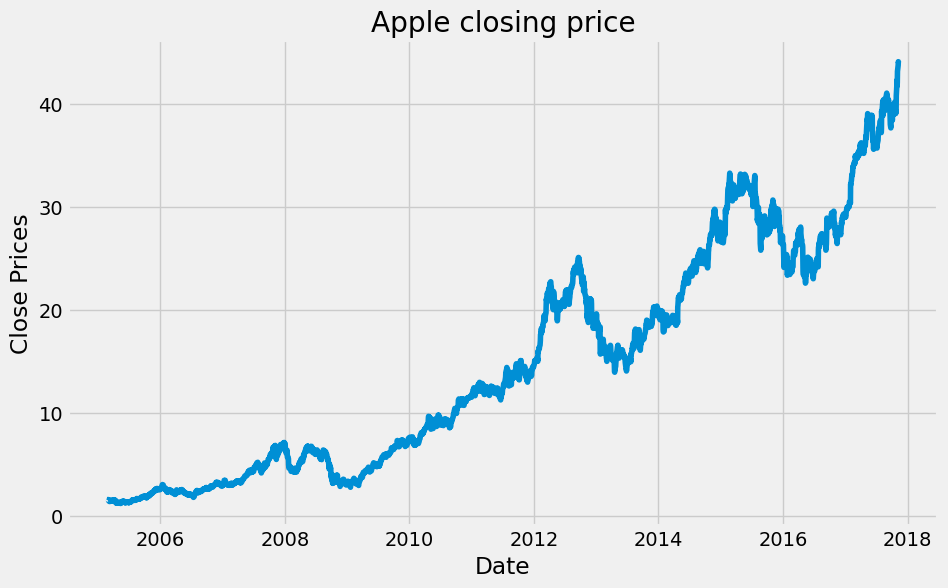

In [ ]:
#plotting the close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('Apple closing price')
plt.show()

In [ ]:
# use the dickey-fuller test to check the stationarity in the time series
def test_stationarity(df_close):
    # Perform Dickey-Fuller test
    result = adfuller(df_close, autolag='AIC')

    # Extract and print test results
    print("Dickey-Fuller Test Results:")
    print(f'Test Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

    # Check the p-value to determine stationarity
    if result[1] <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")












In [ ]:
test_stationarity(df_close)

Dickey-Fuller Test Results:
Test Statistic: 1.0012740459210665
p-value: 0.9942793730386913
Critical Values:
   1%: -3.4324093422917636
   5%: -2.8624498918341525
   10%: -2.5672543561640144
The time series is non-stationary.


<Figure size 1000x600 with 0 Axes>

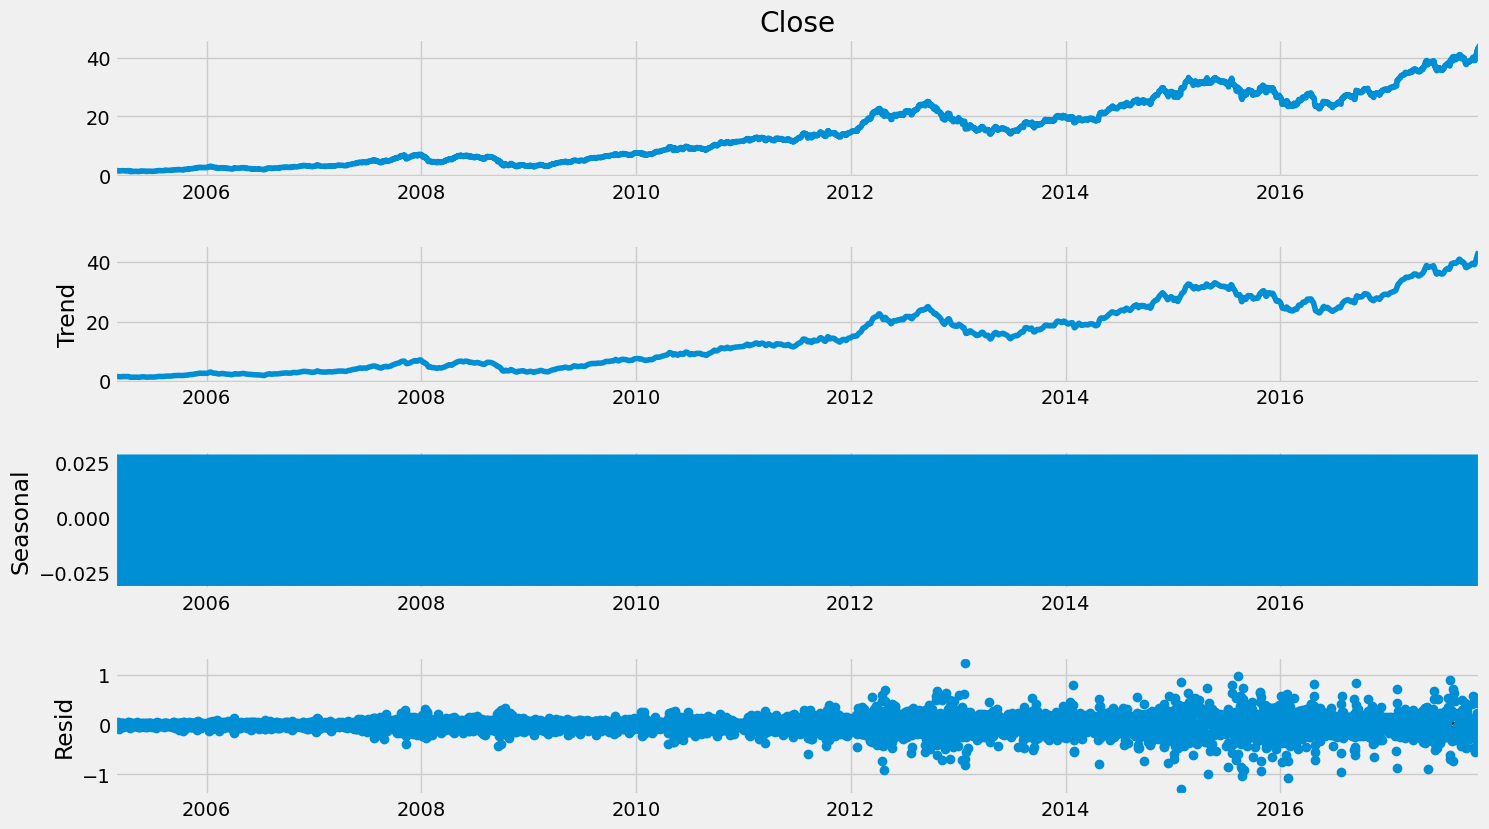

In [ ]:
#To separate the trend and the seasonality from a time series,
# we can decompose the time series .


df_close.index = pd.to_datetime(df_close.index, infer_datetime_format=True)
df_close = df_close.asfreq('D')
df_close = df_close.ffill()

result = seasonal_decompose(df_close, model='additive')#fill code
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

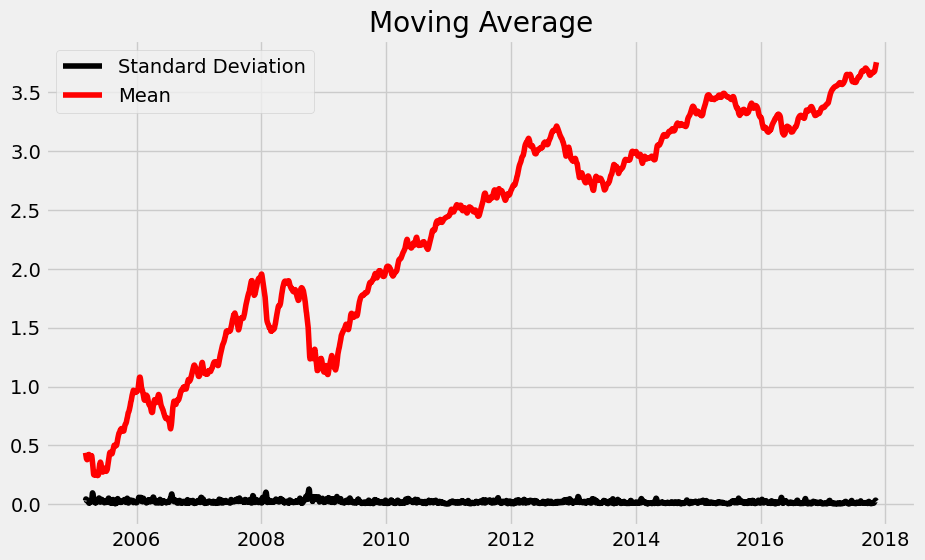

In [ ]:
#Eliminating trend using moving Average and SD
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

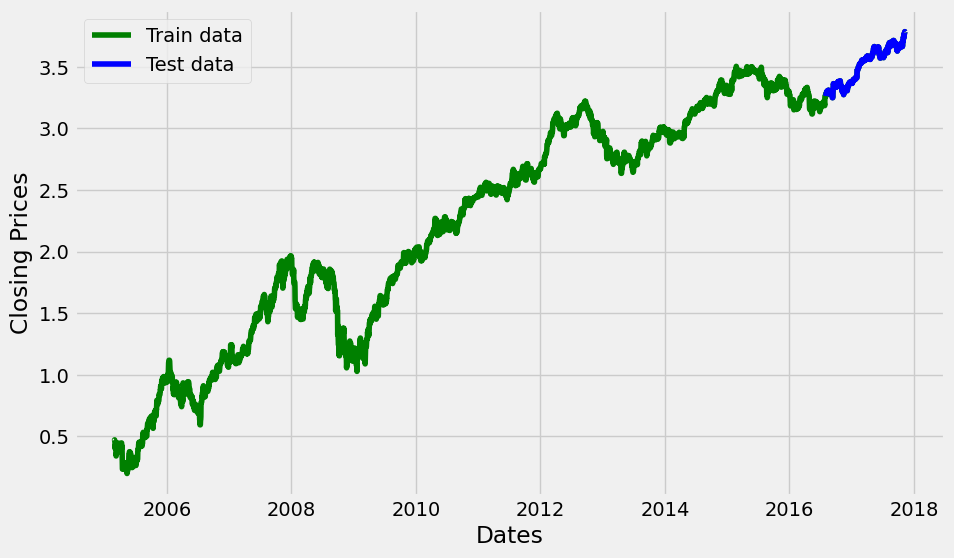

In [ ]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):] #applying log transform for better correlation
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


Its time to choose parameters p,q,d for ARIMA model. Last time we chose the value of p,d, and q by observing the plots of ACF and PACF but now we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-21700.136, Time=0.93 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-21702.032, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-21701.923, Time=1.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21696.282, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-21700.516, Time=1.55 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-21696.836, Time=2.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-21698.592, Time=4.61 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-21697.819, Time=0.40 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 11.760 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4173
Model:               SARIMAX(1, 1, 0)   Log Likelihood               10854.016
Date:                Fri, 28 Jul 2023   AIC                         -21702.032
Time:              

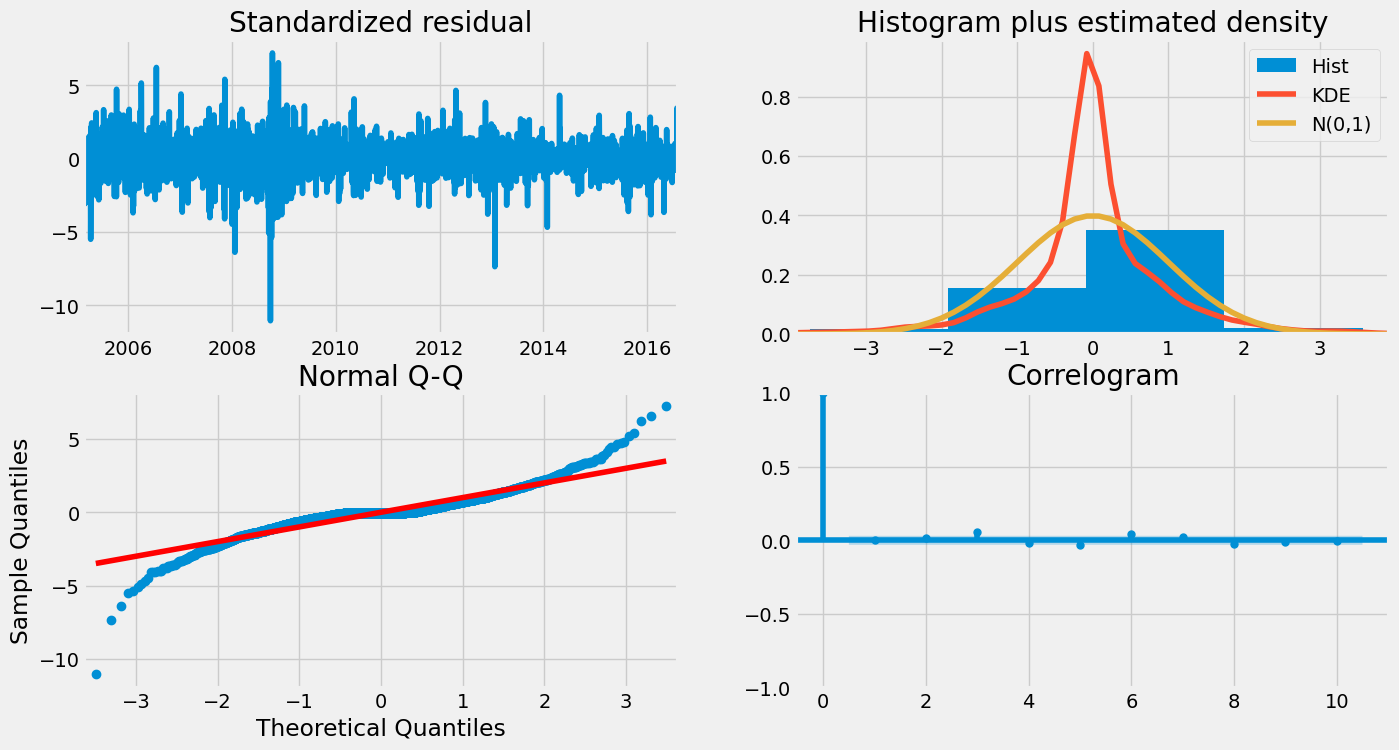

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

**Auto ARIMA model provided the value of p,d, and q use these values to train the arima model.**

In [ ]:
#train the Arima Model with Order (p , d , q)

#Your Code Here
def train(p, d, q):
    model = ARIMA(train_data, order=(p, d, q))
    fitted_model = model.fit()
    return fitted_model



### Now let's start forecast the stock prices on the test dataset keeping 95% confidence level.

In [ ]:
# Forecast
p, d, q = model_autoARIMA.order
arima_model = train(p, d, q)
forecast_steps = 321
fc = arima_model.forecast(321, alpha=0.05)   # 95% conf

Plot the results

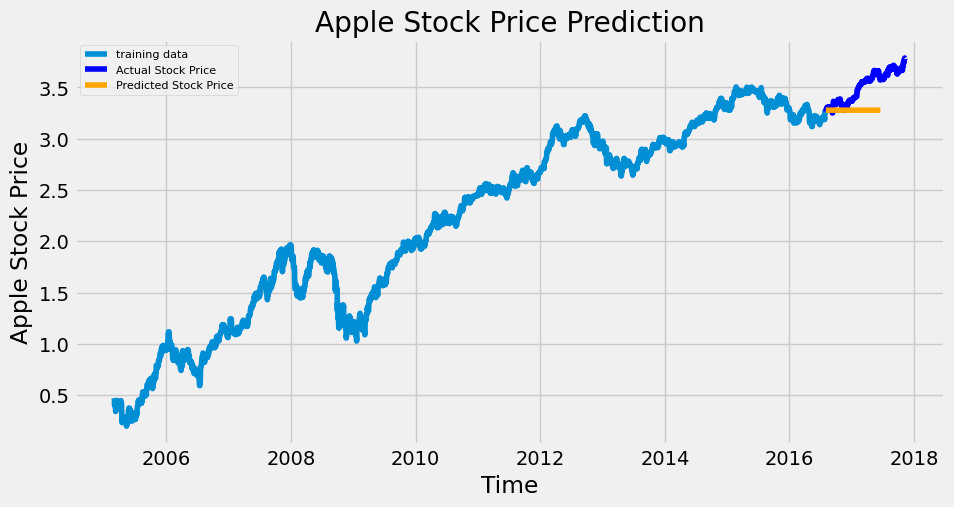

In [ ]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Let us check the commonly used accuracy metrics to judge forecast results:

In [ ]:
#Calculate the RMSE and Absolute error using Scikit Learn Function
test_data_clean = test_data.fillna(method='ffill')
fc_aligned_clean = fc_series.fillna(method='ffill')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data_clean, fc_aligned_clean))
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Absolute Error
mae = mean_absolute_error(test_data_clean, fc_aligned_clean)
print("Mean Absolute Error (MAE):", mae)

Root Mean Squared Error (RMSE): 0.27612334787922616
Mean Absolute Error (MAE): 0.2336162892192434


In [ ]:
#Colab End